In [1]:
### Author: Leonie Küchenhoff
### Date: September 2022
### Purpose of script: 
### 1. Plot venn diagrams of number of variants called by different variant callers

In [2]:
import numpy as np
import pandas as pd
from matplotlib_venn import venn3
from matplotlib import pyplot as plt
import os
from config import basedir, outdir

In [3]:
outdir = str(outdir + '/venn/')
os.chdir(basedir)
db_dir = 'known_variants_vcfs/overlap/'
# path to unfiltered variants
paths = ['merged/ad_hc_mu/HLT279.correctedgt.dbinfo.txt',
        'merged/ad_hc_mu/HLT282.correctedgt.dbinfo.txt',
        'merged/ad_hc_mu/HLT450.correctedgt.dbinfo.txt']
# sample names
names = ['279', '282', '450']

In [ ]:
# read variant files
file_dict = {}
for i in zip(paths, names):
    df = pd.read_csv(i[0], delimiter = '\t')
    file_dict[i[1]] = df

In [45]:
def get_sets(df):
    '''
    function to get info where gt is  0/1 or 1/1 in the shape of a binary mask
    returns binary mask and indices of locations where variant is present
    '''
    # separate info from GT into two arrays (before: '0,1' - after: allel1 = [0], allel2 = [1])
    allel1 = df.applymap(lambda x: x[0]).to_numpy()
    allel2 = df.applymap(lambda x: x[2]).to_numpy()
    # replace '.' with -1 to ba able to use integers
    allel1[allel1 == '.'] = -1
    allel2[allel2 == '.'] = -1
    # transform arrays of strings to integer arrays
    allel1 = allel1.astype(int)
    allel2 = allel2.astype(int)
    # find all gt that are eiher 1/0 or 0/1 or 1/1 and create binary mask
    gt = allel1 + allel2
    binary = gt > 0
    # create ascending list of length of table that will be later used for venn diagrams
    setlist = np.arange(0,len(gt))
    return binary, setlist

In [46]:
venn_dict = {}
for i in names:
     # get GT information from complete list of variants and tissues 
    mouse_gt = file_dict[i][['GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']]
    # get GT information from complete list that exlcudes known variants
    mouse_gt_unknown = file_dict[i][
        (file_dict[i]['known_dbsnp'].isna() & file_dict[i]['known_mgp'].isna())
        ][
        ['GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']]  
    # get info where gt is  0/1 or 1/1 in the shape of a binary mask  
    binary_all, setlist_all = get_sets(mouse_gt)
    binary_uk, setlist_uk = get_sets(mouse_gt_unknown)
    venn_dict[i] = [binary_all, setlist_all, binary_uk, setlist_uk]

In [47]:
def get_snp_indel(df):
    '''
    function to extract all variants that are snps 
    (both reference and alternative are of length 1)
    input: variant df with ref and alt column
    output: variant df with all columns with snp
    '''
    ref = df['ref'].str.len()
    alt = df['alt'].str.len()
    snp = ((ref == 1) & (alt == 1))
    snp_df = df[snp]
    indel_df = df[np.invert(snp)]
    return snp_df, indel_df

In [48]:
snp_dict = {}
indel_dict = {}
for i in names:
    snp_dict[i], indel_dict[i] = get_snp_indel(file_dict[i])

In [49]:
# create separate dictionaries for all variants and unknown variants
venn_dict_known = {}
venn_dict_unknown = {}
for i in names:
    # get GT information from complete list of variants and tissues 
    mouse_gt = file_dict[i][[
        'GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']
        ]
    mouse_gt_snp = snp_dict[i][
        ['GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']
        ]
    mouse_gt_indel = indel_dict[i][
        ['GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']
        ]
    # get GT information from complete list that excludes known variants
    mouse_gt_unknown = file_dict[i][
        (file_dict[i]['known_dbsnp'].isna() & file_dict[i]['known_mgp'].isna())
        ][
        ['GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']]
    mouse_gt_unknown_snp = snp_dict[i][
        (snp_dict[i]['known_dbsnp'].isna() & snp_dict[i]['known_mgp'].isna())
        ][
        ['GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']]  
    mouse_gt_unknown_indel = indel_dict[i][
        (indel_dict[i]['known_dbsnp'].isna() & indel_dict[i]['known_mgp'].isna())
        ][
        ['GT|h_hc','GT|l_hc','GT|t_hc','GT|h_mu','GT|l_mu','GT|t_mu', 'GT|h_ls','GT|l_ls','GT|t_ls']]
    # get info where gt is  0/1 or 1/1 in the shape of a binary mask    
    binary_all, setlist_all = get_sets(mouse_gt)
    binary_uk, setlist_uk = get_sets(mouse_gt_unknown)
    binary_all_snp, setlist_all_snp = get_sets(mouse_gt_snp)
    binary_uk_snp, setlist_uk_snp = get_sets(mouse_gt_unknown_snp)
    binary_all_indel, setlist_all_indel = get_sets(mouse_gt_indel)
    binary_uk_indel, setlist_uk_indel = get_sets(mouse_gt_unknown_indel)
    # save info in shape of dictionaries
    venn_dict_known[i] = [binary_all, setlist_all, binary_all_snp, setlist_all_snp, binary_all_indel, setlist_all_indel] 
    venn_dict_unknown[i] = [binary_uk, setlist_uk, binary_uk_snp, setlist_uk_snp, binary_uk_indel, setlist_uk_indel]

In [ ]:
plt.rcParams.update({'font.size':16, 'text.usetex': False,
"svg.fonttype": 'none'})

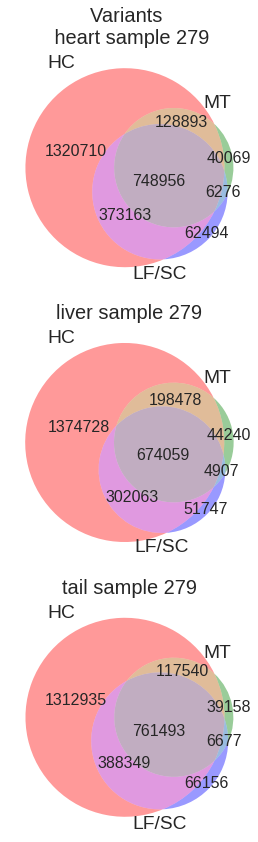

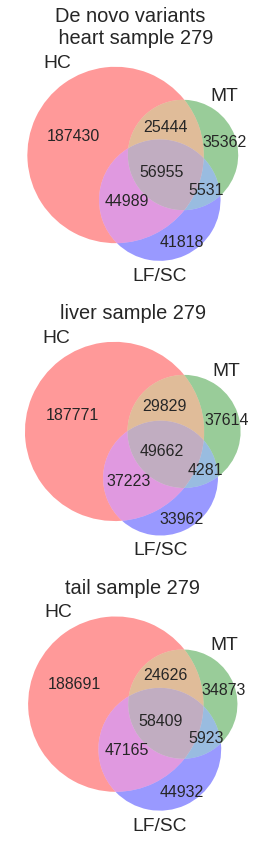

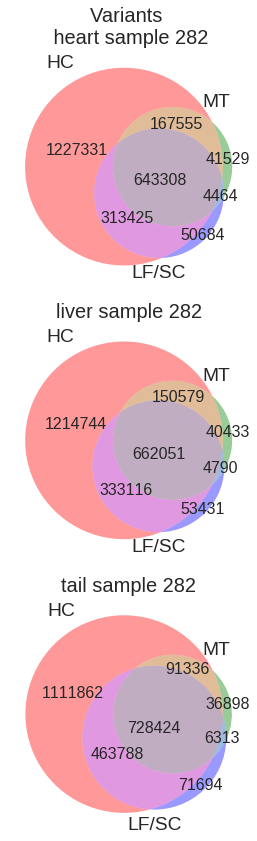

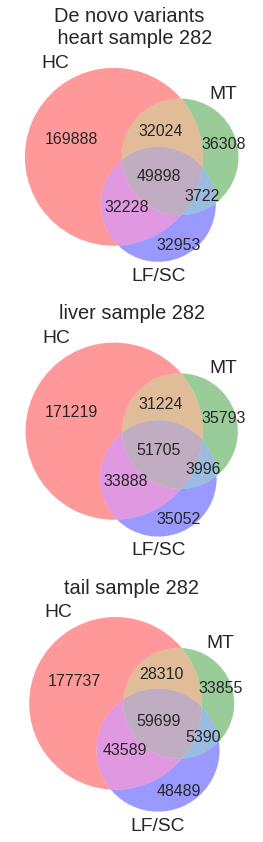

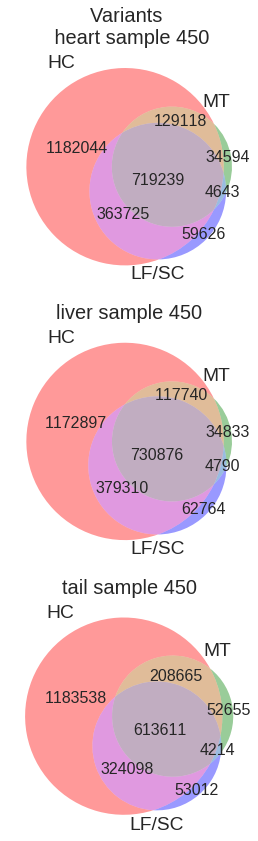

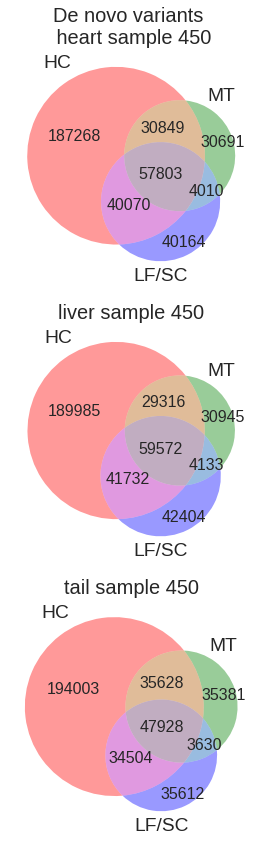

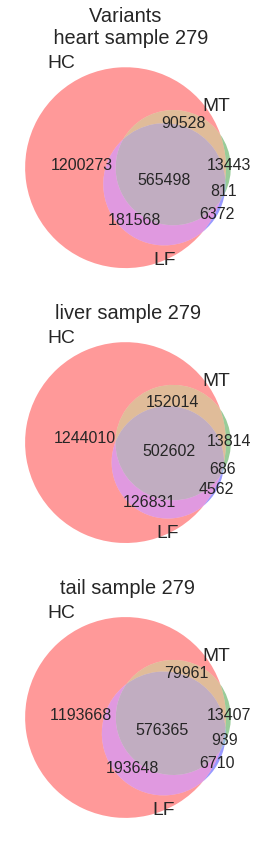

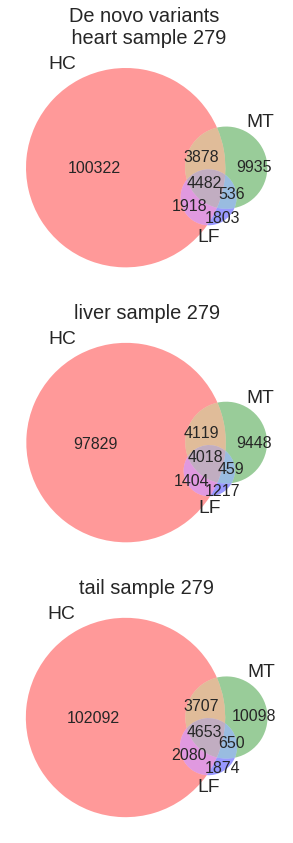

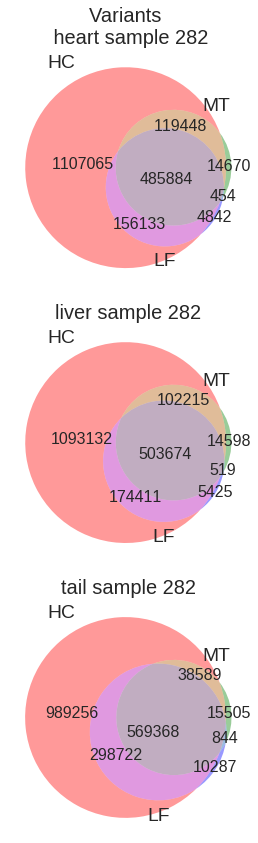

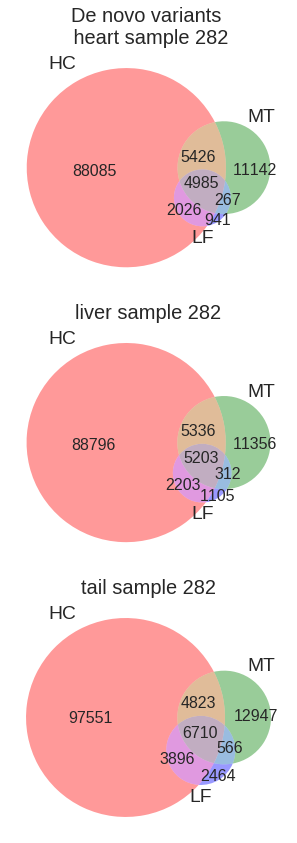

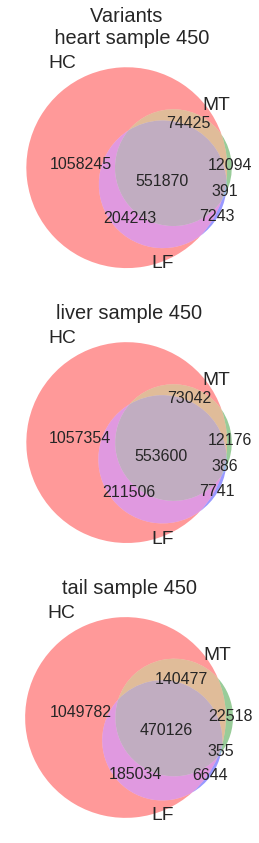

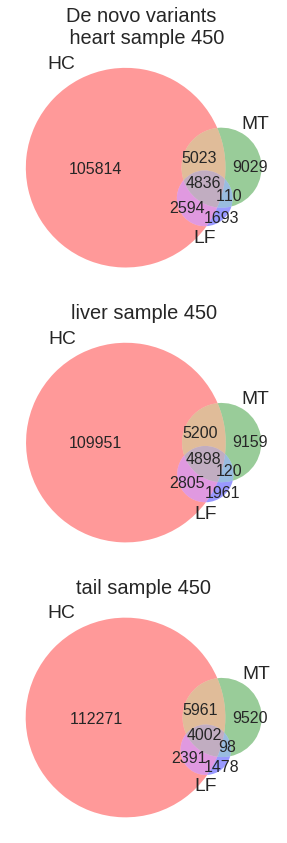

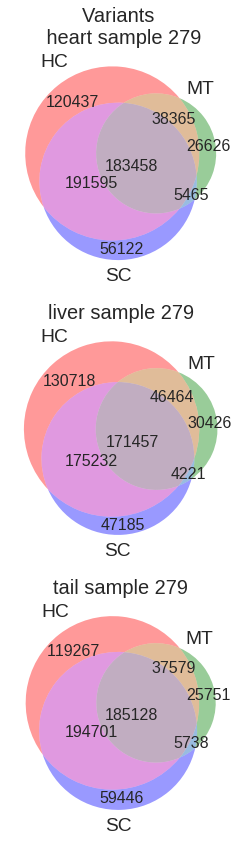

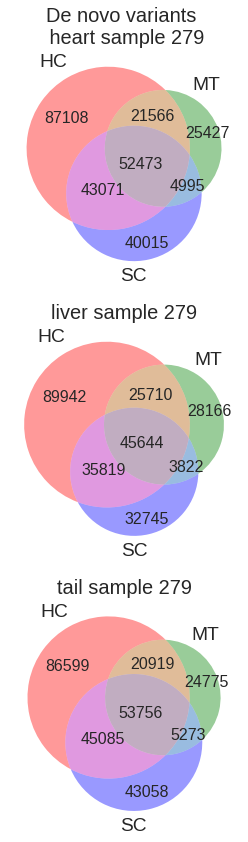

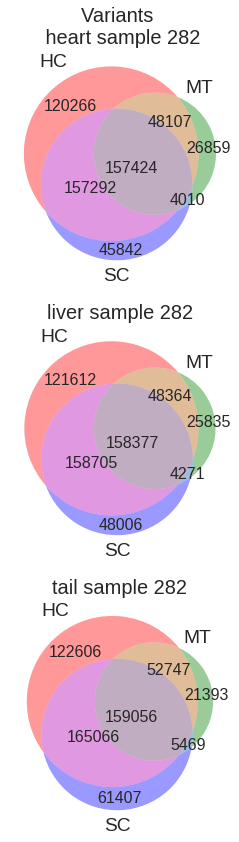

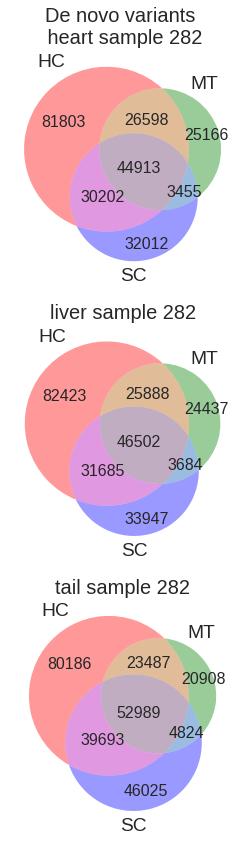

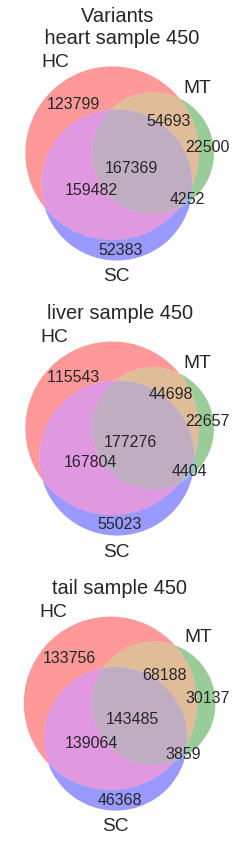

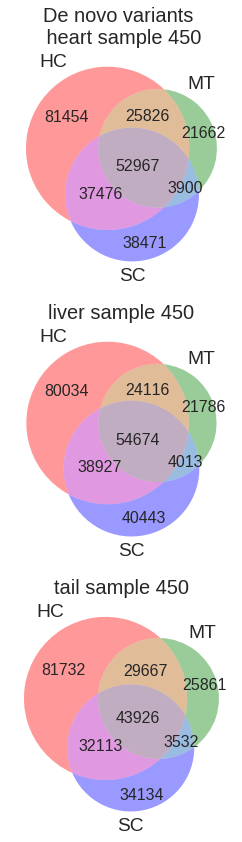

In [50]:
# Plot data in shape of venn diagrams for all groups
for count, j in enumerate(['both', 'snps', 'indels']):
    for i in names:
        # first count: plot snps + indels, then plot only snps, then plot only indels
        binary = venn_dict_known[i][count*2]  
        setlist = venn_dict_known[i][(count*2) + 1]
        
        if j == 'both':
            labels = ('HC', 'MT', 'LF/SC')
        elif j == 'snps':
            labels = ('HC', 'MT', 'LF')
        elif j == 'indels':
            labels = ('HC', 'MT', 'SC')

        fig, ax = plt.subplots(3, figsize = (7,12))
        v1 = venn3([set(setlist[binary[:,0]]), 
                    set(setlist[binary[:,3]]), 
                    set(setlist[binary[:,6]])], 
                    set_labels = labels,
                    ax = ax[0])
        v2 = venn3([set(setlist[binary[:,1]]), 
                    set(setlist[binary[:,4]]), 
                    set(setlist[binary[:,7]])],
                    set_labels = labels,
                    ax = ax[1])
        v3 = venn3([set(setlist[binary[:,2]]), 
                    set(setlist[binary[:,5]]), 
                    set(setlist[binary[:,8]])],
                    set_labels = labels,
                    ax = ax[2])
        ax[0].set_title(f'Variants \n heart sample {i}', fontsize = 20)      
        ax[1].set_title(f'liver sample {i}', fontsize = 20) 
        ax[2].set_title(f'tail sample {i}', fontsize = 20)
        plt.tight_layout()
        plt.savefig(f'{outdir}/venn_all_{i}_{j}.pdf', bbox_inches='tight')
        plt.savefig(f'{outdir}/venn_all_{i}_{j}.svg', bbox_inches='tight')
        plt.show()

        binary = venn_dict_unknown[i][count*2]  
        setlist = venn_dict_unknown[i][(count*2) + 1]  
        fig, ax = plt.subplots(3, figsize = (7,12))
        v1 = venn3([set(setlist[binary[:,0]]), 
                    set(setlist[binary[:,3]]), 
                    set(setlist[binary[:,6]])], 
                    set_labels = labels,
                    ax = ax[0])
        v2 = venn3([set(setlist[binary[:,1]]), 
                    set(setlist[binary[:,4]]), 
                    set(setlist[binary[:,7]])],
                    set_labels = labels,
                    ax = ax[1])
        v3 = venn3([set(setlist[binary[:,2]]), 
                    set(setlist[binary[:,5]]), 
                    set(setlist[binary[:,8]])],
                    set_labels = labels,
                    ax = ax[2])
        ax[0].set_title(f'De novo variants \n heart sample {i}', fontsize = 20)      
        ax[1].set_title(f'liver sample {i}', fontsize = 20) 
        ax[2].set_title(f'tail sample {i}', fontsize = 20)
        plt.tight_layout()
        #fig.savefig(f'{outdir}/venn_unknownvar_{i}_{j}.pdf', bbox_inches='tight')
        #fig.savefig(f'{outdir}/venn_unknownvar_{i}_{j}.svg', bbox_inches='tight')
        plt.show()